# Walkthrough Example

In this short file, we will show an example of fitting an interventional factor model (IFM), based on the Sachs et al. paper, [Causal Protein-Signaling Networks Derived from Multiparameter Single-Cell Data](https://www.science.org/doi/10.1126/science.1105809) (Science, 2005). 

In this notebook, we will:

1. Load data from 9 different sources with different settings of interventional variables
2. Fit this data to a bespoke IFM based on the results of Sachs et al.
3. Generate an artificial model for an artificial outcome variable
4. Build a simulator that generates data from the fitted model and artificial outcome variable
5. Use the simulator to generate a Monte Carlo estimator of the ground truth mapping between interventions and outcome

---

## Interventional Variables, Regimes and Random Variables

The original Sachs et al. paper contains data on 9 experimental conditions of a biological system of 11 variables. The interventional variables are all binary:

1. `CD3CD28off`
2. `ICAM-2`
3. `Akt-inhibitor`
4. `G0076`
5. `Psitectorigenin`
6. `U0126`
7. `LY294002`
8. `PMA`
9. `B2camp`

Nine regimes are generated. Below, we will encode them as 9-character binary strings corresponding to the 9 intervention variables above. Notice that we call the first condition `CD32CD28off` with an "off" in the end to denote that `CD32CD28off = 0` are the conditions where this stimulus is enforced and `CD32CD28off = 1` means that this stimulus is not on. This is so that regime `000000000` is the baseline.

1. `000000000`
2. `010000000`
3. `001000000`
4. `000100000`
5. `000010000`
6. `000001000`
7. `000000100`
8. `100000010`
9. `100000001`

Notice the interaction between `CD3CD28off` and {`PMA`, `B2camp`}.

The 11 random variables are called:

1. `praf`
2. `pmek`
3. `plcg`
4. `PIP2`
5. `PIP3`
6. `p44/42`
7. `pakts473`
8. `PKA`
9. `PKC`
10. `P38`
11. `pjnk`

They are all continuous. Notice that several uses of the Sachs et al. data (including their own!) discretize these variables.

From now on, we refer to the first group of variables as **intervention variables** $F_1, F_2, \dots, F_9$, while the latter group be called the **random variables** $X_1, X_2, \dots, X_{11}$.

---

## DAG Model

The following DAG structure is suggested by the results of Sachs et al. It can be disputed (among other things, Sachs et al. assume all $F_i \rightarrow X_j$ edges, while e.g. [Eaton and Murphy (2007)](https://proceedings.mlr.press/v2/eaton07a.html) learn these edges too and produce a different graph. In both cases, acyclicity is taken for granted).

$F_1$ (`CD3CD28off`) and $F_2$ (`ICAM-2`) point to all random variables. $F_{7}$ is ignored for some reason in the Eaton and Murphy paper (its target among the 11 random is not very clear), let's ignore it here too. The "target specific" $F_i \rightarrow X_j$ edges are

1. $F_3 \rightarrow X_7$
2. $F_4 \rightarrow X_9$
3. $F_5 \rightarrow X_4$
4. $F_6 \rightarrow X_2$
5. $F_8 \rightarrow X_9$
6. $F_9 \rightarrow X_8$

The DAG among observed variables is

1. $X_1 \rightarrow X_2$
2. $X_2 \rightarrow X_6$
3. $X_3 \rightarrow \{X_4, X_9\}$
4. $X_4 \rightarrow X_9$
5. $X_5 \rightarrow \{X_3, X_4, X_7\}$
6. $X_6 \rightarrow X_7$
7. $X_7 \rightarrow None$
8. $X_8 \rightarrow \{X_1, X_2, X_6, X_7, X_{10}, X_{11}\}$
9. $X_9 \rightarrow \{X_1, X_2, X_8, X_{10}, X_{11}\}$
10. $X_{10} \rightarrow None$
11. $X_{11} \rightarrow None$



## Simplified Setup

Two of the conditions (`PMA`, `B2camp`) are entangled with `CD3CD28off` (e.g., `PMA` $= 1 \Rightarrow$ `CD3CD28off` $= 1$). We propose leaving these two out in first instance. This also means `CD3CD28off` is now always 0, so we can treat it as implicit. `ICAM-2` affects everybody, and likewise we could treat `LY294002` as also being a global intervention. For simplicity, let's drop those two also to look at case where no intervention has more than one child. This leaves us with four possible interventions. 

1. `Akt-inhibitor`
2. `G0076`
3. `Psitectorigenin`
4. `U0126`

We now have **five corresponding regimes** in the data:

1. `0000` (dataset `cd3cd28.csv`)
2. `1000` (dataset `cd3cd28+aktinhib.csv`)
3. `0100` (dataset `cd3cd28+g0076.csv`)
4. `0010` (dataset `cd3cd28+psitect.csv`)
5. `0001` (dataset `cd3cd28+u0126.csv`)

We *could* call the above four intervention variables $F_1, F_2, F_3$ and $F_4$. This also leads to the simplified "intervention to random variable" graph given by

1. $F_1 \rightarrow X_7$
2. $F_2 \rightarrow X_9$
3. $F_3 \rightarrow X_4$
4. $F_4 \rightarrow X_2$

The **dose-response curve** is defined for all $2^4$ possible conditions, with `0000` being the baseline.

**However**, because the code is such that we are currently implementing DAG models where each random variable has exactly one intervention parent, for the sake of keeping that code we are calling the four intervention variables above as

$\sigma_7$. `Akt-inhibitor`

$\sigma_9$. `G0076`

$\sigma_4$. `Psitectorigenin`

$\sigma_2$. `U0126`,

where $\sigma_1, \sigma_3$ etc. are dummy intervention variables that have only single state `0`. The intervention-to-random subgraph is therefore

1. $\sigma_1 \rightarrow X_1$
2. $\sigma_2 \rightarrow X_2$
3. $\sigma_3 \rightarrow X_3$
4. $\sigma_4 \rightarrow X_4$
...,

up to $\sigma_{11} \rightarrow X_{11}$.

---

## Interpretation of DAG as Interventional Factor Model

The resulting interventional factor graph implied by the DAG is formed by making a factor out of each triplet $(child, random~parents, interventional~parents)$ implied by the DAG. This leads to a factorization $$p(x; \sigma) \propto \prod_{k = 1}^{11} f_k(x_{S_k}; \sigma_{F_k})$$ where:

1. $S_1 = \{V_1, V_8, V_9\}, F_1 = \{\sigma_1\}$
2. $S_2 = \{V_2, V_1, V_8, V_9\}, F_2 = \{\sigma_2\}$
3. $S_3 = \{V_3, V_5\}, F_3 = \{\sigma_3\}$
4. $S_4 = \{V_4, V_3, V_5\}, F_{4} = \{\sigma_4\}$
5. $S_5 = \{V_5\}, F_{5} = \{\sigma_5\}$
6. $S_6 = \{V_6, V_2, V_8\}, F_{6} = \{\sigma_6\}$
7. $S_7 = \{V_7, V_5, V_6, V_8\}, F_{7} = \{\sigma_7\}$
8. $S_8 = \{V_8, V_9\}, F_{8} = \{\sigma_8\}$
9. $S_9 = \{V_9, V_3, V_4\}, F_{9} = \{\sigma_9\}$
10. $S_{10} = \{V_{10}, V_8, V_9\}, F_{10} = \{\sigma_{10}\}$
11. $S_{11} = \{V_{11}, V_8, V_9\}, F_{11} = \{\sigma_{11}\}$

---

## Initialization and Data Loading

This assumes that the relevant data is stored as `.csv` files in a subdirectory called `dat`. The data is transformed by taking logarithms (making it much closer to symmetric). Below, we also define the DAG structure and the interventional factor graph structure.

First, we load all source files and libraries that we need.

In [61]:
########## Import relevant libraries 

include("ifm.jl")
include("util.jl")
include("other_learning.jl")
include("benchmark_tools.jl");

Now, we load the real data, transform it, and define the corresponding DAG and IFM graph structures.

In [2]:
# Raw mediator data ("X" measurements) on the 5 regimes selected in Sachs et al.
my_path = "dat/"
file_names = ["1. cd3cd28.csv", 
              "3. cd3cd28+aktinhib.csv", 
              "4. cd3cd28+g0076.csv",
              "5. cd3cd28+psitect.csv",
              "6. cd3cd28+u0126.csv"]
x_data = Vector{Matrix{Float64}}(undef, length(file_names))
for (i, file_name) in enumerate(file_names)
    # Log-scale makes things easier here
    x_data[i] = log.(readdlm(my_path * file_name, ',', Float64; header=true)[1])
end
group_normalize!(x_data) # The normalization is across all 5 regimes, so no data file
                            # will end up with zero mean/unit standard deviation

# Interventional data, and combination of them by using a function from the included code
sigma_data = zeros(Int, 5, 11)
sigma_data[2, 7] = 1 # Akt-inhibitor set to 1, all the others at 0
sigma_data[3, 9] = 1 # G0076 set to 1, all the others at 0
sigma_data[4, 4] = 1 # Psitectorigenin set to 1, all the others at 0
sigma_data[5, 2] = 1 # U0126 set to 1, all the others at 0
sigma_train = sigma_data
num_regimes = size(sigma_data)[1]

# Causal structure given by Sachs et al.: DAG and factor graph model variations
num_x = 11
sigma_scope = zeros(Int, num_x)
for i in (7, 9, 4, 2) sigma_scope[i] = 1; end # Each sigma is binary, maximum value in sigma_scope[i] is 1
sigma_all = build_categorical_design_matrix(sigma_scope) # All 16 combinations of sigma variables
num_all_regimes = size(sigma_all, 1)

# DAG
pa_x = Vector{Vector{Int}}(undef, num_x)
pa_x[1]  = [8, 9]
pa_x[2]  = [1, 8, 9]
pa_x[3]  = [5]
pa_x[4]  = [3, 5]
pa_x[5]  = []
pa_x[6]  = [2, 8]
pa_x[7]  = [5, 6, 8]
pa_x[8]  = [9]
pa_x[9]  = [3, 4]
pa_x[10] = [8, 9]
pa_x[11] = [8, 9]

# IFM
factors_x = Vector{Vector{Int}}(undef, num_x)
for i in 1:num_x
    factors_x[i] = [i; pa_x[i]]
end

Let's do some visualization of the real data, contrasting the same variable in two regimes (baseline regime of `1` and alernative regime `sigma_id`).

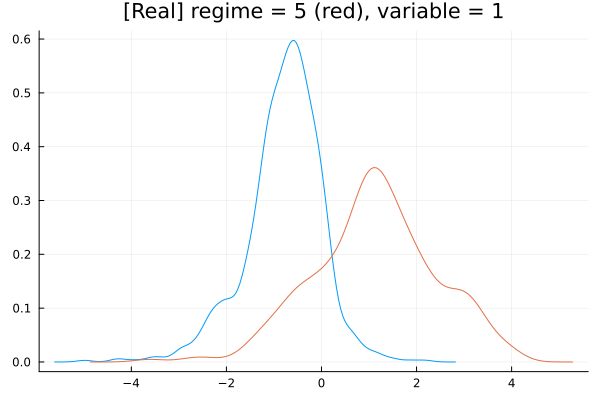

In [9]:
x_choice, sigma_id = 1, 5

m_rv = "[Real] regime = " * string(sigma_id) * " (red), variable = " * string(x_choice)
plot_me = density(x_data[1][:, x_choice], title = m_rv)
density!(x_data[sigma_id][:, x_choice], title = m_rv)
plot(plot_me, legend = false)

---

## Synthetic Ground Truth and Training Data Generation

Now, we fit the real data to the IFM defined above to generate "realistic" ground truth synthetic models for process variables $X$ with sixteen possible values for intervention vector $\sigma_1, \dots, \sigma_{11}$, since only four $\sigma$ variables can take a value other then `0`. We then generate an artificial ground truth response function with random outcome $Y$. This synthetic outcome model is given by $$Y = \tanh(\lambda_{true}^{\mathsf T}X) + \epsilon_y.$$

First, let's fit the IFM that will play the role of ground truth. This non-optimized code will take a few minutes (10-15) to conclude.

In [14]:
# Create and fit a IFM model as synthetic ground truth to generate process X

num_levels_ifm_groundtruth = 20   # Number of discretization levels for IFM
num_hidden_ifm_groundtruth = 15   # Number of hidden units for each factor in the IFM
rho_ifm, max_iter_ifm = 0.1, 120  # Adam optimization parameters for IFM learning

groundtruth_ifm_theta, progress_ifm, groundtruth_ifm, _, _, groundtruth_ifm_dx_support, _ = 
    learn_ifm(x_data, sigma_data, factors_x, sigma_scope, num_levels_ifm_groundtruth, num_hidden_ifm_groundtruth, rho_ifm, max_iter_ifm, false);

Let's plot its progress. You will see variability, as this is done my mini-batches.

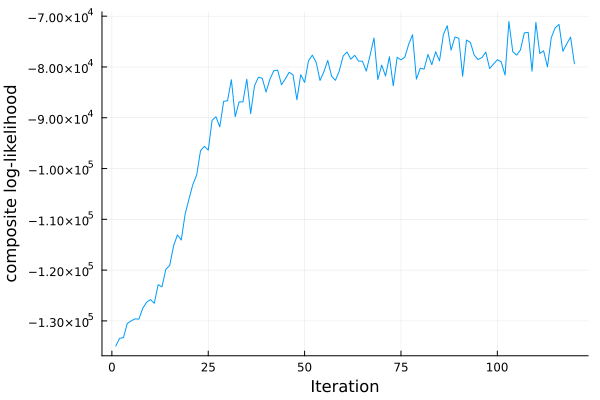

In [15]:
plot(progress_ifm, xlabel="Iteration", ylabel="composite log-likelihood", legend=false)

Now, we sample from this fitted model to create a ground truth distribution $p(x; \sigma)$ as represented by a (Markov chain) Monte Carlo sample `montecarlo_x_ifm`.

In [16]:
m = 50000            # Number of samples for Monte Carlo approximation of ground truth functionals
burn_in_ifm = 1000   # Burn in for IFM MCMC sampling

montecarlo_x_ifm = Vector(undef, num_all_regimes)
println("Sampling from IFM ground truth...")
for i = 1:num_all_regimes
    println("[REGIME ", i, "/", num_all_regimes, "]")
    montecarlo_x_ifm[i] = sample_ifm_gibbs(m, burn_in_ifm, groundtruth_ifm, sigma_all[i, :], groundtruth_ifm_theta, groundtruth_ifm_dx_support, false)
end

Sampling from IFM ground truth...


[REGIME 1/16]


[REGIME 2/16]


[REGIME 3/16]


[REGIME 4/16]


[REGIME 5/16]


[REGIME 6/16]


[REGIME 7/16]


[REGIME 8/16]


[REGIME 9/16]


[REGIME 10/16]


[REGIME 11/16]


[REGIME 12/16]


[REGIME 13/16]


[REGIME 14/16]


[REGIME 15/16]


[REGIME 16/16]


The next stage is to generate the synthetic $p(y~|~x)$, and compute the corresponding $\mu_\sigma := \mathbb E[Y; \sigma]$ by Monte Carlo, storing them into array `true_y_ifm` (16 entries for this Sachs et al. case study). As mentioned above, this is done by $Y = \tanh(\lambda_{true}^{\mathsf T}X) + \epsilon_y$, where `lambda_true_ifm` is chosen randomly as below.

In [20]:
# Artificial outcome model ("Y" variable), controlled to have empirical variance of y_signal_strength
# at the observational regime, prior to non-linearity and error. The error will have variance of
# 1 - y_signal_strenght

y_signal_strenght = rand() * 0.2 + 0.6 # Signal to noise ratio, between 0.6 and 0.8
y_var_error_true = 1. - y_signal_strenght
pre_lambda_true = rand(Normal(), num_x)
pre_var_y = var(montecarlo_x_ifm[1] * pre_lambda_true)
lambda_true_ifm = pre_lambda_true ./ sqrt(pre_var_y) * sqrt(y_signal_strenght)

 # "True" expected values under all regimes of interest (in the three models), as estimated using Monte Carlo
true_y_ifm = zeros(Float64, num_all_regimes, 1)
true_var_y_ifm = zeros(Float64, num_all_regimes, 1)
for i = 1:num_all_regimes
    dat = tanh.(montecarlo_x_ifm[i] * lambda_true_ifm) + rand(Normal(), size(montecarlo_x_ifm[i], 1)) .* sqrt(y_var_error_true)
    true_y_ifm[i, 1], true_var_y_ifm[i, 1] = mean(dat), var(dat)
end

To recap: the above generates a ground truth representation of $p(x; \sigma)$ implicitly by the IFM structure `groundtruth_ifm` with parameters `groundtruth_ifm_theta`, discretized into support points `groundtruth_ifm_dx_support`. This also comes with an explicit Monte Carlo representation `montecarlo_x_ifm`, each entry `montecarlo_x_ifm[i]`, $i = 1, 2, 3, \dots, 16$, corresponding to a different regime. The outcome model $p(y~|~x)$ is implicitly defined by `lambda_true_ifm` and `y_var_error_true`, with Monte Carlo approximations of $\mu_y$ given by `true_y_ifm`.

What we will do next is to generate *training data*. The training data is sampled independently from the ground truth models. Recall that for our Sachs et al. case study, we pretend we have access only to 5 regimes (`0000`, `1000`, `0100`, `0010`, `0001`), with `0000` denoting a "baseline" regime. That is, even though we have the ability of sampling whatever we want from the ground truth, in this hypothetical synthetic scenario we will limit ourselves to the same regimes as found in the original Sachs et al. study.

In [23]:
sample_size = 500     # Default sample size for each regime
factor_baseline = 10  # Factor by which we multiple sample_size to define the sample size of baseline regime (1)

# Generate training X data
n_data = sample_size .* ones(Int, num_regimes); n_data[1] *= factor_baseline # Training sample size
burn_in_ifm = 100
train_dat_ifm = Vector(undef, num_regimes)
println("Sampling IFM training data...")
for i = 1:num_regimes
    train_dat_ifm[i] = sample_ifm_gibbs(n_data[i], burn_in_ifm, groundtruth_ifm, sigma_data[i, :], 
                                        groundtruth_ifm_theta, groundtruth_ifm_dx_support, false)
end

# Generate training Y data
y_train_ifm = Vector{Matrix{Float64}}(undef, num_regimes)
for i = 1:num_regimes
    y_train_ifm[i] = Matrix{Float64}(undef, n_data[i], 1)
    y_train_ifm[i][:, 1] = tanh.(train_dat_ifm[i] * lambda_true_ifm) + rand(Normal(), n_data[i]) .* sqrt(y_var_error_true)
end


Sampling IFM training data...


To wrap up this section, the following provides plots for data generated by the fitted IFM ground truth model.

Target variables modified directly by regime 6 are 

1 2 5 6 7 8 9


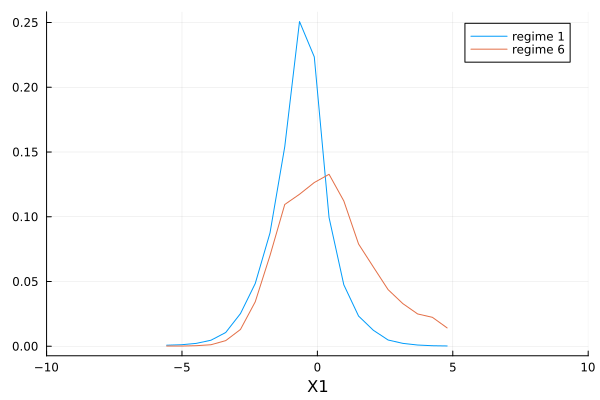

In [51]:
x_id = 1       # A variable of interest
r_id = [1, 6]  # Two possible different regimes

for r in r_id
    modified = findall(sigma_all[r, :] .> 0)
    if length(modified) > 0
        mod = []
        [append!(mod, factors_x[i]) for i in modified]
        mod = sort(unique(mod))
        print("Target variables modified directly by regime ", r, " are")
        [print(" ", m) for m in mod]
        println()
    end
end

plot(groundtruth_ifm_dx_support[x_id], empirical_discrete_frequencies(montecarlo_x_ifm[r_id_1][:, x_id], 
     groundtruth_ifm_dx_support[x_id]), xlim=(-10, 10), label="regime " * string(r_id[1]),
     xlabel="X" * string(x_id))
plot!(groundtruth_ifm_dx_support[x_id], empirical_discrete_frequencies(montecarlo_x_ifm[r_id_2][:, x_id], 
      groundtruth_ifm_dx_support[x_id]), xlim=(-10, 10), label="regime " * string(r_id[2]))

---

## Model Evaluation

First, we fit a DAG model to the training data and learn the outcome by marginalizing the DAG. We then generate a Monte Carlo representation of the fitted $\hat p_{DAG}(x; \sigma)$. This could take up to an hour to run: a heteroscedatic non-linear Gaussian model is used for each factor and cross-validated variable per variable, and this takes time.

In [56]:
x_train = Vector{Matrix{Float64}}(undef, num_regimes)
[x_train[i] = train_dat_ifm[i] for i = 1: num_regimes]

num_hidden_dag_mean, num_hidden_dag_var = 10, 10 # Number of hidden units for DAG (non-linear Gaussian heteroscedastic) models
rho_dag, max_iter_dag = 0.1, 300                 # Adam optimization parameters for DAG
m = 5000                                         # Number of Monte Carlo samples

learned_dag_model = causal_dag_learning(x_train, sigma_train, pa_x, sigma_scope, num_hidden_dag_mean, num_hidden_dag_var, rho_dag, max_iter_dag, false)
x_dag_hat_montecarlo = sample_causal_dag(learned_dag_model, sigma_all, m .* ones(Int, num_all_regimes), false);

16-element Vector{Matrix{Float64}}:
 [0.5924557779961052 -0.8783607939574378 … -2.851022651482216 0.7474426938409522; 0.37587912268712986 -0.7984345674727882 … -0.40429333110835325 0.2664971580868942; … ; 0.2965990875228376 -0.9030207053322494 … 0.05530158010568498 -1.1622621810661866; -1.883203072543141 -2.639705622791209 … -0.24631409453056752 -2.2739462059795343]
 [-0.1379490153372524 0.3138271802757868 … -4.856264631144382 -0.9202891986524682; -1.124345916702855 -0.67503213965042 … 0.1562907036297837 -0.5807544648973363; … ; -0.38222553133812953 0.07279219665874825 … -4.486847116419277 -1.7975435371952477; -1.8809116082947699 -1.1147062947468083 … 0.12260689476152123 0.3405628003855615]
 [-0.9571591207197118 -1.5583585667335362 … 1.20054306894266 -0.7900281130845561; -0.06231306859224317 -2.2773596265307754 … -0.6611611979907562 -0.006667110714205227; … ; -0.020705852658388424 -2.1830682041499445 … 2.7141309397729487 2.9673550766063985; 0.20713890961033032 0.8774505625605802 … 6.85

We now fit an IFM to the training data, and sample accordingly. This will take about 5-10 minutes.

In [62]:
rho = 0.1                    # Adam IFM optimizer hyperparameter, the higher the "jumpier"
max_iter = 150               # Number of optimization iterations for IFM
num_hidden_ifm = 25          # Number of hidden units for IFM. Notice that it overshoots what the true model does.
num_levels = 20              # Number of discretization levels for IFM
burn_in = 100                # To skip at the beginning of Gibss sampling from the fitted model

println("Fitting IFM...")
theta_ifm_hat, fun_ifm_hat, ifm_hat, dx_train, dx_train_code, dx_support, dx_buckets  = 
        learn_ifm(x_train, sigma_train, factors_x, sigma_scope, num_levels, num_hidden_ifm, rho, max_iter, false)

println("Sampling predictive IFM samples...")
x_ifm_hat_montecarlo = Vector{Matrix{Float64}}(undef, num_all_regimes)
for i = 1:num_all_regimes
    x_ifm_hat_montecarlo[i] = sample_ifm_gibbs(m, burn_in, ifm_hat, sigma_all[i, :], theta_ifm_hat, dx_support, false);
end

Fitting IFM...


Sampling predictive IFM samples...


What we are going to do now is to learn the outcome model for the DAG and black-box approaches, the latter defined in terms of gradient boosting from the design matrix `sigma_train` to the outcome training data `y_train_ifm`.

In [128]:
println("Fitting blackbox outcome...")
y_hat_blackbox, _ = blackbox_learning(y_train_ifm, sigma_train, sigma_all);

println("Fitting DAG outcome...")
y_hat_dag = batch_mediator_predict(x_dag_hat_montecarlo, sigma_all, [x_train], [y_train_ifm], false);

println("Fitting IFM1 outcome...")
y_hat_ifm_1 = batch_mediator_predict(x_ifm_hat_montecarlo, sigma_all, [x_train], [y_train_ifm], false);

println("Fitting IFM2 outcome...")
y_hat_ifm_2, _ = batch_mediator_predict(sigma_all, x_train, [y_train_ifm], sigma_train, ifm_hat, theta_ifm_hat, false);

Fitting blackbox outcome...


Fitting DAG outcome...


Fitting IFM1 outcome...


Fitting IFM2 outcome...


Now, let's print a matrix comparing these methods.

In [130]:
# Report results

include_sigma = findall(sum(sigma_all, dims = 2)[:, 1] .> 1)

result_frame = DataFrame([sigma_all[:, [2, 4, 7, 9]] true_y_ifm y_hat_blackbox y_hat_dag' y_hat_ifm_1' y_hat_ifm_2'], :auto)
result_frame[!, 1:4] = convert.(Int, result_frame[:, 1:4])
rename!(result_frame, [:s2, :s4, :s7, :s9, :true_y, :blackbox, :dag, :ifm1, :ifm2])
println(result_frame)
println()
println("pMSE (blackbox) : ", mean((true_y_ifm[include_sigma] - y_hat_blackbox[include_sigma]).^2 ./ true_var_y_ifm[include_sigma]))
println("pMSE (DAG)      : ", mean((true_y_ifm[include_sigma] - y_hat_dag[include_sigma]).^2 ./ true_var_y_ifm[include_sigma]))
println("pMSE (IFM1)     : ", mean((true_y_ifm[include_sigma] - y_hat_ifm_1[include_sigma]).^2 ./ true_var_y_ifm[include_sigma]))
println("pMSE (IFM1)     : ", mean((true_y_ifm[include_sigma] - y_hat_ifm_2[include_sigma]).^2 ./ true_var_y_ifm[include_sigma]))


16×9 DataFrame
 Row │ s2     s4     s7     s9     true_y     blackbox   dag        ifm1       ifm2       
     │ Int64  Int64  Int64  Int64  Float64    Float64    Float64    Float64    Float64    
─────┼────────────────────────────────────────────────────────────────────────────────────
   1 │     0      0      0      0  -0.213555  -0.191781  -0.164607  -0.216239  -0.208595
   2 │     1      0      0      0   0.258856   0.277954  -0.144021   0.32014    0.270223
   3 │     0      1      0      0   0.540354   0.541067   0.269511   0.317796   0.5217
   4 │     1      1      0      0   0.772554   0.541067   0.274311   0.65181    0.665728
   5 │     0      0      1      0  -0.39427   -0.346801  -0.165045  -0.42181   -0.43961
   6 │     1      0      1      0  -0.111744   0.277954  -0.144124  -0.071856  -0.112161
   7 │     0      1      1      0   0.42286    0.541067   0.269536   0.22143    0.397802
   8 │     1      1      1      0   0.575344   0.541067   0.271545   0.462776   0.596813
   

---

## Conclusion

The above presents a simple simulation comparing the three main methods we discuss in the paper. The implementation of DAG is slow, but partially to try to give the power to generate less boring examples with fitting it to real data as a ground truth model (homoscedastic additive errors is too simple of an assumption for a generative model). As a matter of fact, the implementation provide in the Julia files are basic implementations which allow only over intervention variable per factor, which itself is known to be naive ([Eaton and Murphy (2007)](https://proceedings.mlr.press/v2/eaton07a.html)). Future work includes an implementation allowing any set of intervention variables per factor, itself conceptually trivial but which leads to more complicated code.

Now that you have seen this example, please go to `workflow_examples.jl` for a batch experimental with both Sachs et al. and DREAM, as well as the generation of multiple synthetic output models and a DAG-based groundtruth generation.